# Differential pair generator
```
Time Transcenders Team, July 2025
SPDX-License-Identifier: Apache-2.0
```

**PCell Generators**
1. Primitive Cells / `glayout.primitives`
  - FET (NMOS, PMOS)
  - MIM Capacitor
  - Guard Rings with Metalization
  - Via

In [15]:
import numpy as np

In [1]:
from glayout import sky130, gf180
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

from gdsfactory import Component
from gdsfactory.components import rectangle, text_freetype

from glayout import rename_ports_by_orientation

In [2]:
from glayout.primitives.via_gen import via_stack, via_array
from glayout.primitives.fet import nmos, pmos, multiplier
from glayout.primitives.guardring import tapring

In [3]:
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.comp_utils import move, movex, movey
from glayout.util.port_utils import PortTree, rename_ports_by_orientation
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist

In [4]:
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

In [5]:
# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

### 1. Primitives
#### MOSFET (nmos/pmos)

**Parameters:**
- **pdk:** Which PDK to use
- **width:** Width of one finger (um)
- **length:** Length of one finger (um). The default value is the minimum channel length available
- **fingers:** Number of fingers per transistor
- **multipliers:** Number of transistors in this cell
- **with_tie:** bool
- **with_dummy:** tuple of 2 bools
- **with_dnwell:** bool
- **with_substrate_tap:** bool
- **sd_route_topmet:** Expose the S/D connection on which metal layer
- **gate_route_topmet:** Expose the Gate connection on which metal layer
- **sd_route_left:** Choose which direction the S/D connection goes to
- **rmult:** Integer multipler of routing width
- **sd_rmult:** Same as above
- **gate_rmult:** Same as above
- **interfinger_rmult:** Same as above
- **tie_layers:** Run the body tie metal on which layer. This entry is a tuple with 2 elements
    - X metal
    - Y metal
- **substrate_tap_layers:** Run the substrate tie metal on which layer. This entry is a tuple with 2 elements
    - X metal
    - Y metal
- **dummy_routes:** Enable routing to the dummy transistors

Note that most of the parameters have a default value. The user usually doesn't need to populate all of them.

## Defining the arguments for each of the two transistors

![alt text](./diff_pair_img.png "Differential Pair topology")

In [6]:
M1_kwargs = {
    "with_tie": False,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 2,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": False
}

M2_kwargs = {
    "with_tie": False,
    "with_dnwell": False,
    "sd_route_topmet": "met2",
    "gate_route_topmet": "met2",
    "sd_route_left": True,
    "rmult": None,
    "gate_rmult": 2,
    "interfinger_rmult": 1,
    "substrate_tap_layers": ("met2","met1"),
    "dummy_routes": False
}

In [7]:
diff_pair_config={
        "pdk": gf180, # pdk to use
        "placement" : "vertical", # the two fets can be placed either vertically or horizontally
        "width": (20,20), # width of the M1 and M2 respectively.
        "length": (None,None), # length of the M1 and M2 respectively. None refers to the min length in the pdk.
        "fingers": (5,5), # no. of fingers M1 and M2 fet respectively.
        "multipliers": (1,1), #no. of multipliers of the M1 and M2 fet respectively.
        "dummy_1": (True,True), # dummy pattern for M1 fet (left,right)
        "dummy_2": (True,True), # dummy pattern for M2 (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers 
        "tie_layers2": ("met2","met1"), #tapring metal layers 
        "sd_rmult":2, # thickness of the sd metal layer.
}

In [8]:
width=diff_pair_config["width"]
length=diff_pair_config["length"]
fingers=diff_pair_config["fingers"]
multipliers=diff_pair_config["multipliers"]

dummy_1=diff_pair_config["dummy_1"]
dummy_2=diff_pair_config["dummy_2"]
tie_layers1=diff_pair_config["tie_layers1"]
tie_layers2=diff_pair_config["tie_layers2"]
sd_rmult=diff_pair_config["sd_rmult"]

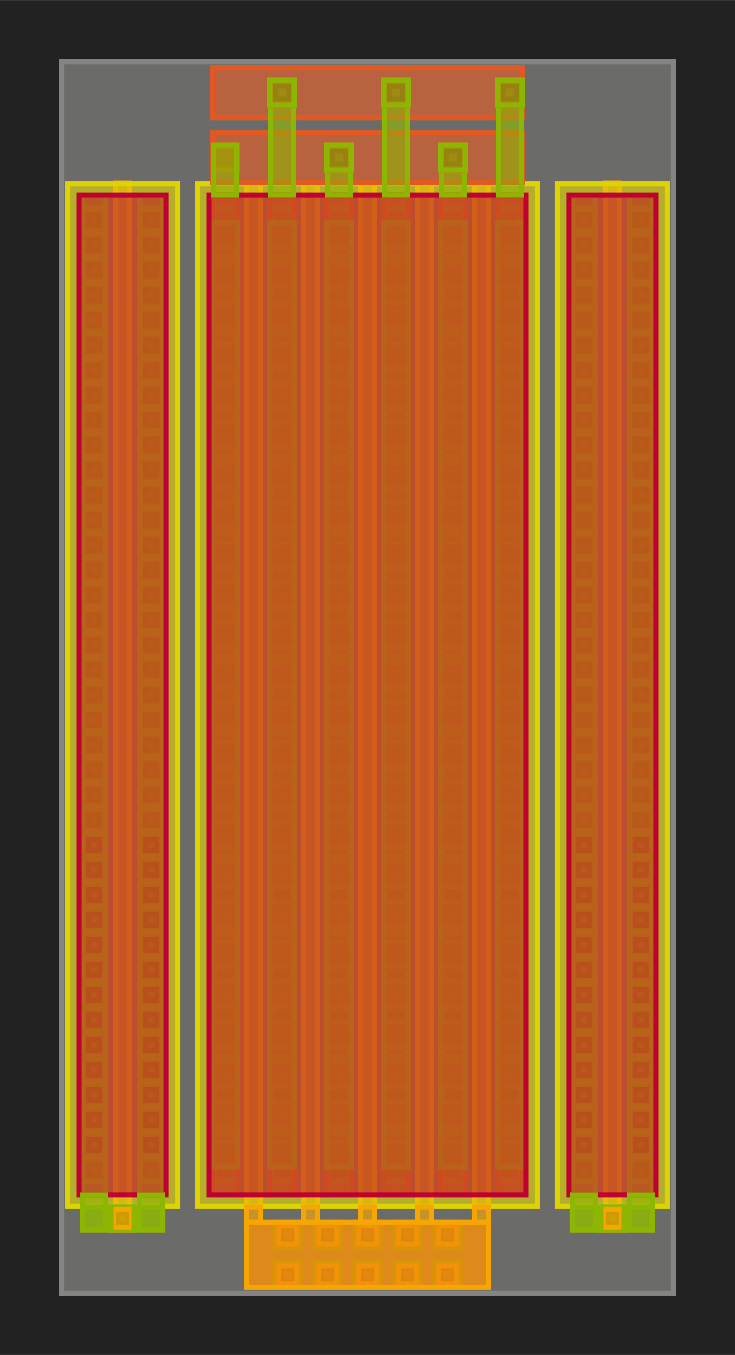

In [26]:
top_level = Component(name="differential_pair")
pdk = diff_pair_config["pdk"]    

M1 = nmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **M1_kwargs)
M2 = nmos(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, **M2_kwargs)

M1_ref = top_level << M1
M2_ref = top_level << M2

M1_ref.name="M1"
M2_ref.name="M2"

display_component(top_level, scale = 5)


### Placement

In [27]:
placement=diff_pair_config["placement"]
ref_dimensions = evaluate_bbox(M2)

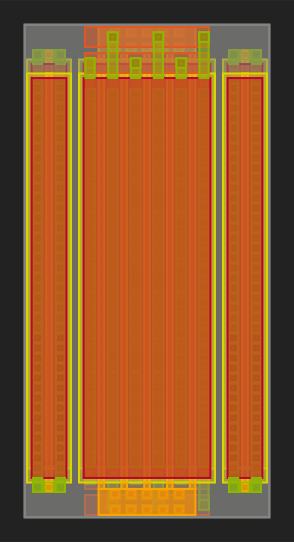

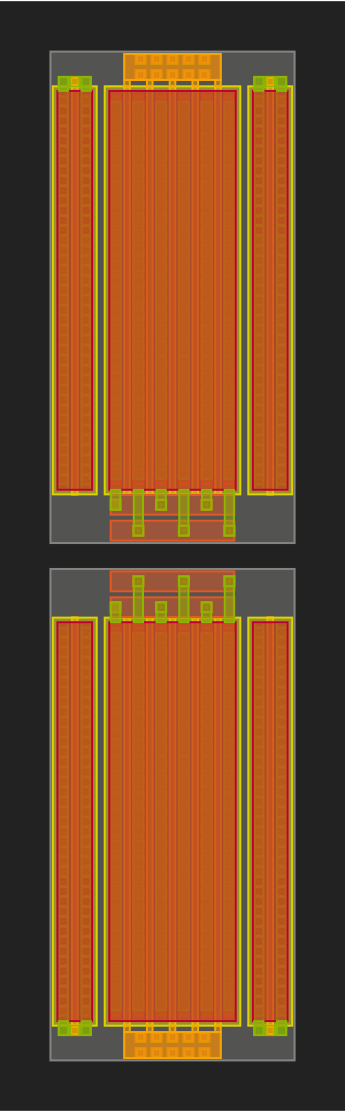

In [28]:
if placement == "horizontal":
    M1_ref.mirror_x()
    # Move M2 to the right, so it's leftmost edge touches the rightmost of M1
    M2_ref.movex(M1_ref.xmax + evaluate_bbox(M2)[0]/2 )
    display_component(top_level, scale = 2)
    # Add some more space between the fets, such that DRC is clean + 0.5um
    M2_ref.movex(pdk.util_max_metal_seperation()+0.5)
elif placement == "vertical":
    M1_ref.mirror_y()
    display_component(top_level, scale = 2)
    M2_ref.movey(M1_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)
else:
        raise ValueError("Placement must be either 'horizontal' or 'vertical'.")
    
# let's see how our block looks after placement

display_component(top_level, scale = 2)

### Adding Tapring Around Differential Pair


Diff pair bounding box: (12.24, 50.58) 
 Diff pair center: [  0.   -12.97]


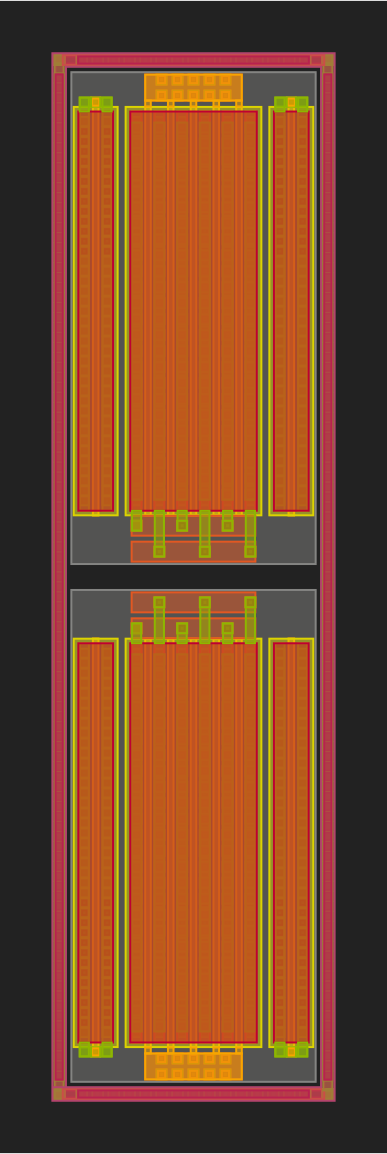

In [29]:
# Center the tapring around the differential pair
diff_pair_center = top_level.center
diff_pair_bbox = evaluate_bbox(top_level)

# Get the bounding box of the differential pair for tapring sizing
print(f"Diff pair bounding box: {diff_pair_bbox} \n Diff pair center: {diff_pair_center}")


# Create the tapring with appropriate parameters
# Using substrate tap for NMOS devices in bulk
tapring_comp = tapring(
    pdk=pdk,
    enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"])
)

# Add the tapring to our component
tapring_ref = top_level << tapring_comp
tapring_ref.name = "bulk_tapring_diff_pair"
tapring_ref.move(diff_pair_center)

display_component(top_level, scale = 2)


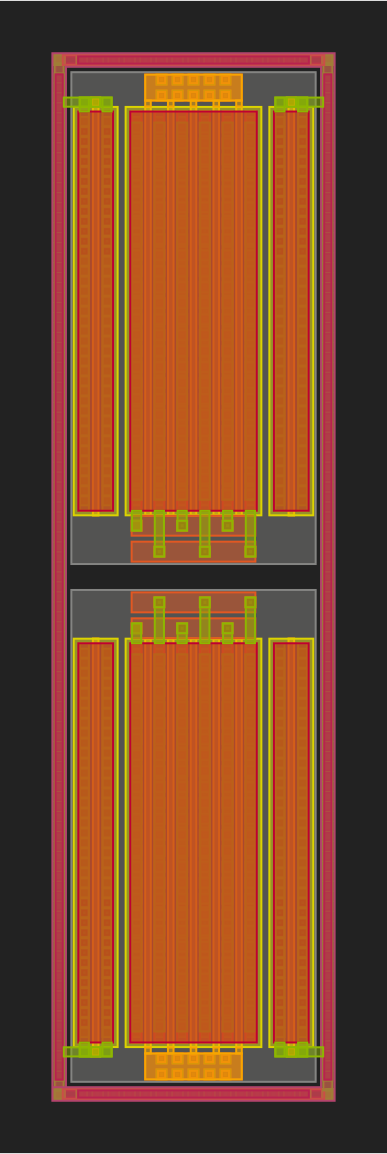

In [30]:
#display_component(top_level, scale = 2)
dummy_ports = [port for port in  M1_ref.get_ports_list() if "dummy" in port.name.lower() and "bottom_met" in port.name.lower()]
#print(f"M1 dummy ports found: {len(dummy_ports)}")

M1_gdscon_L = M1_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"].center
M1_gdscon_R = M1_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"].center
M2_gdscon_L = M2_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"].center
M2_gdscon_R = M2_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"].center

tapring_ports = [port for port in  tapring_ref.get_ports_list() if "bottom_met" in port.name.lower()]
#print(tapring_ports)
# - multiplier_0_dummy_L_gsdcon_bottom_met_E: [-4.67 10.82]
# - multiplier_0_dummy_R_gsdcon_bottom_met_E: [ 5.13 10.82]
# - multiplier_0_dummy_L_gsdcon_bottom_met_W: [-5.13 10.82]
# - multiplier_0_dummy_R_gsdcon_bottom_met_W: [ 4.67 10.82]

distances_L_M1 = []
distances_R_M1 = []
distances_L_M2 = []
distances_R_M2 = []

for port in tapring_ports:
    port_pos = np.array(port.center)
    #for gdscon in [M1_gdscon_L, M1_gdscon_R, M2_gdscon_L, M2_gdscon_R]:
    distance_temp = np.linalg.norm(M1_gdscon_L - port_pos)
    distances_L_M1.append((distance_temp, port))    
    distance_temp = np.linalg.norm(M1_gdscon_R - port_pos)
    distances_R_M1.append((distance_temp, port))    
    distance_temp = np.linalg.norm(M2_gdscon_L - port_pos)
    distances_L_M2.append((distance_temp, port))    
    distance_temp = np.linalg.norm(M2_gdscon_R - port_pos)
    distances_R_M2.append((distance_temp, port))

# Sort by distance and get closest
closest_distance_L, closest_port_L_M1 = min(distances_L_M1, key=lambda x: x[0])
closest_distance_R, closest_port_R_M1 = min(distances_R_M1, key=lambda x: x[0])
closest_distance_R, closest_port_L_M2 = min(distances_L_M2, key=lambda x: x[0])
closest_distance_R, closest_port_R_M2 = min(distances_R_M2, key=lambda x: x[0])



top_level << straight_route(pdk, M1_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"], tapring_ref.ports[closest_port_L_M1.name])
top_level << straight_route(pdk, M1_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"], tapring_ref.ports[closest_port_R_M1.name])
top_level << straight_route(pdk, M2_ref.ports["multiplier_0_dummy_L_gsdcon_bottom_met_E"], tapring_ref.ports[closest_port_L_M2.name])
top_level << straight_route(pdk, M2_ref.ports["multiplier_0_dummy_R_gsdcon_bottom_met_W"], tapring_ref.ports[closest_port_R_M2.name])

display_component(top_level, scale = 2)


### Routing 

In [41]:
viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.
viam3m4 = via_stack(pdk, "met3", "met4", centered=True)

# Vias for signals
sig_A_via = top_level << viam3m4
sig_B_via = top_level << viam3m4

# Vias for M1
drain_M1_via = top_level << viam2m3
source_M1_via = top_level << viam2m3
gate_M1_via = top_level << viam2m3

# Vias for M2
drain_M2_via = top_level << viam2m3
source_M2_via = top_level <<viam2m3
gate_M2_via = top_level << viam2m3

The move function moves the center of a specific cell to a specific co-ordinate. The co-ordinates of the center of a port can be accesed by using cell_name.ports["port_name"].center Using these two and other techniques previously discussed, we properly place these 4 vias.

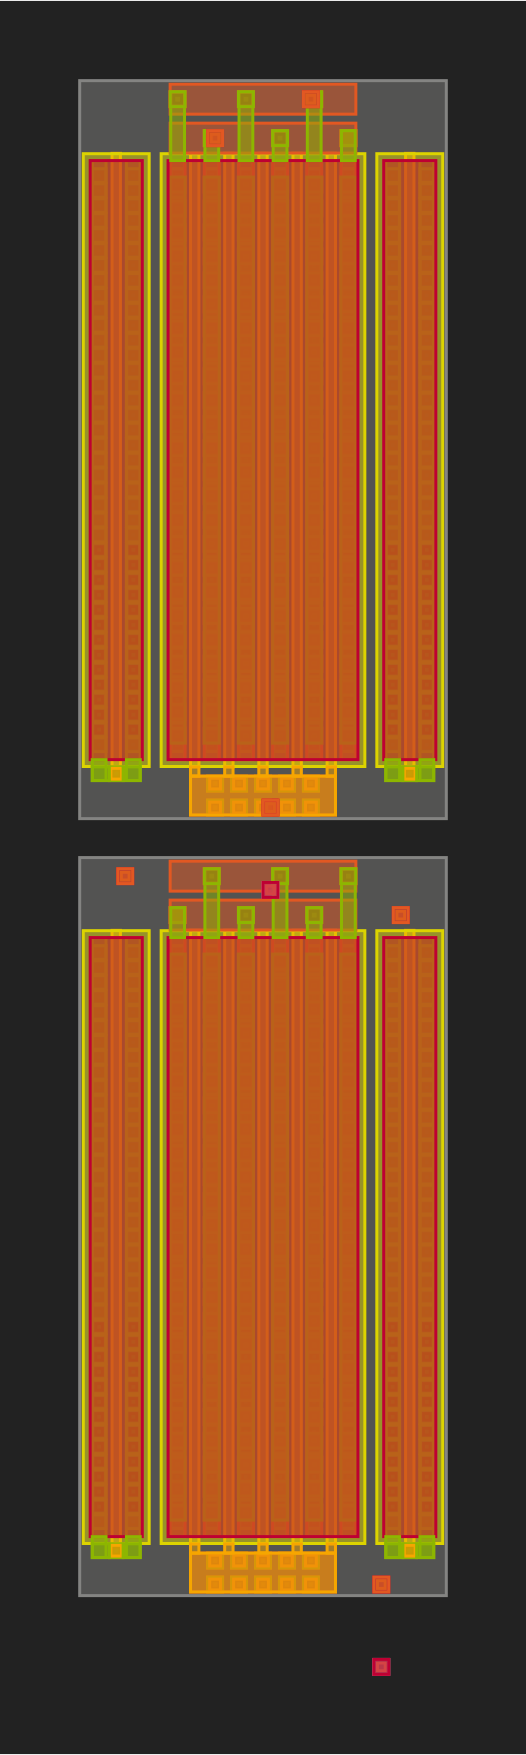

In [42]:
drain_M1_via.move(M1_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)
drain_M2_via.move(M2_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)

# align source vias to the source stubs of M1 and M2
source_M1_via.move(M1_ref.ports["multiplier_0_source_E"].center).movex(1.5)
source_M2_via.move(M2_ref.ports["multiplier_0_source_E"].center).movex(1.5)

# align gate vias to the gate stubs of M1 and M2
gate_M1_via.move(M1_ref.ports["multiplier_0_gate_E"].center).movex(2.1)
gate_M2_via.move(M2_ref.ports["multiplier_0_gate_E"].center).movex(2.1)

# align signal vias with the gate ports of the FETs
sig_A_via.move(gate_M1_via.ports["bottom_met_N"].center).movey(-3)
sig_B_via.move(gate_M2_via.ports["bottom_met_N"].center).movey(-3)


## To see in Klayout via Klive
#top_level.show()
display_component(top_level, scale = 3)

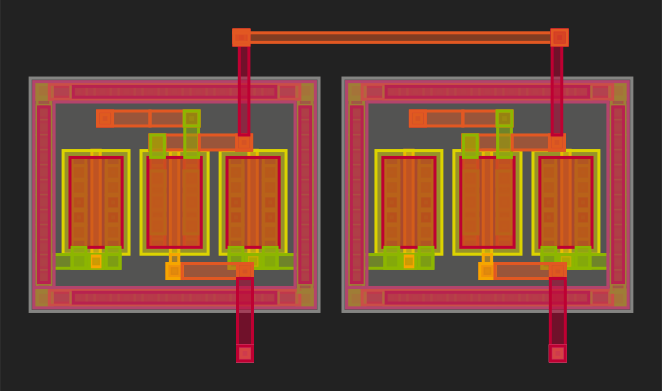

In [14]:
# Connect drain vias with the drains of M1 and M2
top_level << straight_route(pdk, M1_ref.ports["multiplier_0_drain_W"], drain_M1_via.ports["bottom_met_W"])
top_level << straight_route(pdk, M2_ref.ports["multiplier_0_drain_W"], drain_M2_via.ports["bottom_met_W"])

# Connect source vias with the sources of M1 and M2
top_level << straight_route(pdk, M1_ref.ports["multiplier_0_source_E"], source_M1_via.ports["bottom_met_E"])
top_level << straight_route(pdk, M2_ref.ports["multiplier_0_source_E"], source_M2_via.ports["bottom_met_E"])

# Connect gate vias with the gates of M1 and M2
top_level << straight_route(pdk, M1_ref.ports["multiplier_0_gate_E"], gate_M1_via.ports["bottom_met_E"])
top_level << straight_route(pdk, M2_ref.ports["multiplier_0_gate_E"], gate_M2_via.ports["bottom_met_E"])

# Connect the signal vias to the gate vias
top_level << straight_route(pdk, gate_M1_via.ports["top_met_S"], sig_A_via.ports["top_met_N"])
top_level << straight_route(pdk, gate_M2_via.ports["top_met_S"], sig_B_via.ports["top_met_N"])


if placement == "horizontal":
    # connect the sources of M1 and M2
    top_level << c_route(pdk, source_M1_via.ports["top_met_N"], source_M2_via.ports["top_met_N"],extension=1*max(width[0],width[1]), width1=0.32, width2=0.32, cwidth=0.32, e1glayer="met3", e2glayer="met3", cglayer="met2")

display_component(top_level, scale = 3)

In [15]:
component = top_level.flatten()
component.name = "diff_pair"

pdk_root_gf180="/usr/local/share/pdk"
drc_result = gf180.drc_magic(component, component.name,
                             pdk_root=pdk_root_gf180, 
                             magic_drc_file="{}/gf180mcuD/libs.tech/magic/gf180mcuD.magicrc".format(pdk_root_gf180))

2025-08-18 16:49:16.871 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmpyh3mbvzk/diff_pair.gds'


using provided pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 489 - Compiled on Fri Jun 20 14:01:31 UTC 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmpyh3mbvzk/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "diff_pair".
[INFO]: Loading diff_pair

Loading DRC CIF style.
[INFO]: D

In [69]:
import inspect
sig = inspect.signature(gf180.drc_magic)
print(f"Function signature: {sig}")

Function signature: (layout: gdsfactory.component.Component | str | pathlib.Path, design_name: str, pdk_root: Union[str, pathlib.Path, NoneType] = None, magic_drc_file: Union[str, pathlib.Path, NoneType] = None, output_file: Union[str, pathlib.Path, NoneType] = None) -> dict


In [ ]:
inv_code_string = """
from glayout import MappedPDK, sky130 , gf180
from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle

from glayout import nmos, pmos
from glayout import via_stack
from glayout import rename_ports_by_orientation
from glayout import tapring

from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist

from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

def add_inv_labels(
    inv_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    
    inv_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    # gnd
    gndlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    gndlabel.add_label(text="VBULK",layer=pdk.get_glayer("met3_label"))
    move_info.append((gndlabel,inv_in.ports["N_tie_N_top_met_N"],None))
    #gnd_ref = top_level << gndlabel;



    #suply
    suplabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    suplabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((suplabel,inv_in.ports["P_source_top_met_N"],None))
    #sup_ref = top_level << suplabel;


    # output
    outputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    outputlabel.add_label(text="VOUT",layer=pdk.get_glayer("met3_pin"))
    move_info.append((outputlabel,inv_in.ports["P_drain_top_met_N"],None))
    #op_ref = top_level << outputlabel;


    # input
    inputlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    inputlabel.add_label(text="VIN",layer=pdk.get_glayer("met3_pin"))
    move_info.append((inputlabel,inv_in.ports["P_gate_top_met_N"], None))
    #ip_ref = top_level << inputlabel;


    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            inv_in.add(compref)
    
    return inv_in.flatten()
@cell
def inverter(
        pdk: MappedPDK,
        placement: str = "horizontal",
        width: tuple[float,float] = (3,3),
        length: tuple[float,float] = (None,None),
        fingers: tuple[int,int] = (1,1),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        **kwargs
        ) -> Component:

    pdk.activate()
    
    #top level component
    top_level = Component(name="inverter")

    #two fets
    fet_P = pmos(pdk, width=width[0], fingers=fingers[0], multipliers=multipliers[0], with_dummy=dummy_1, with_substrate_tap=False, length=length[0], tie_layers=tie_layers1, sd_rmult=sd_rmult, **kwargs )
    fet_N = nmos(pdk, width=width[1], fingers=fingers[1], multipliers=multipliers[1], with_dummy=dummy_2, with_substrate_tap=False, length=length[1], tie_layers=tie_layers2, sd_rmult=sd_rmult, with_dnwell=False, **kwargs)
    
    fet_P_ref = top_level << fet_P
    fet_N_ref = top_level << fet_N 
    fet_P_ref.name = "fet_P"
    fet_N_ref.name = "fet_N"

    #Relative move
    ref_dimensions = evaluate_bbox(fet_N)
    if placement == "horizontal":
        fet_N_ref.movex(fet_P_ref.xmax + (ref_dimensions[0]/2) + pdk.util_max_metal_seperation()+1)
    elif placement == "vertical":
        fet_N_ref.movey(fet_P_ref.ymin - ref_dimensions[1]/2 - pdk.util_max_metal_seperation()-1)
    else:
        raise ValueError("Placement must be either 'horizontal' or 'vertical'.")

    #Routing
    viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.
    
    #we need four such vias
    drain_P_via = top_level << viam2m3
    source_P_via = top_level << viam2m3
    gate_P_via = top_level << viam2m3

    drain_N_via = top_level << viam2m3
    gate_N_via = top_level << viam2m3
    
        
    drain_P_via.move(fet_P_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)
    drain_N_via.move(fet_N_ref.ports["multiplier_0_drain_W"].center).movex(-1.5)

    source_P_via.move(fet_P_ref.ports["multiplier_0_source_E"].center).movex(1.5)

    gate_P_via.move(fet_P_ref.ports["multiplier_0_gate_E"].center).movex(1)
    gate_N_via.move(fet_N_ref.ports["multiplier_0_gate_E"].center).movex(1)


    top_level << straight_route(pdk, fet_P_ref.ports["multiplier_0_gate_E"], gate_P_via.ports["bottom_met_N"])
    top_level << straight_route(pdk, fet_N_ref.ports["multiplier_0_gate_E"], gate_N_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, fet_P_ref.ports["multiplier_0_source_E"], source_P_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, fet_P_ref.ports["multiplier_0_drain_W"], drain_P_via.ports["bottom_met_E"])
    top_level << straight_route(pdk, fet_N_ref.ports["multiplier_0_drain_W"], drain_N_via.ports["bottom_met_E"])

    if placement == "horizontal":
        top_level << c_route(pdk, gate_P_via.ports["top_met_S"], gate_N_via.ports["top_met_S"],extension=1.2*max(width[0],width[1]), width1=0.32, width2=0.32, cwidth=0.32, e1glayer="met3", e2glayer="met3", cglayer="met2")
        top_level << c_route(pdk, drain_P_via.ports["top_met_N"], drain_N_via.ports["top_met_N"],extension=1.2*max(width[0],width[1]), width1=0.32, width2=0.32, cwidth=0.32, e1glayer="met3", e2glayer="met3", cglayer="met2")
    elif placement == "vertical":
        top_level << straight_route(pdk, gate_P_via.ports["top_met_S"], gate_N_via.ports["top_met_S"])
        top_level << straight_route(pdk, drain_P_via.ports["top_met_N"], drain_N_via.ports["top_met_N"])
    else:
        raise ValueError("Placement must be either 'horizontal' or 'vertical'.")

    try:
        top_level << straight_route(pdk, fet_N_ref.ports["multiplier_0_source_W"], fet_N_ref.ports["tie_W_top_met_W"], glayer1=tie_layers2[1], fullbottom=True)
    except:
        pass

    top_level.add_ports(fet_P_ref.get_ports_list(), prefix="P_")
    top_level.add_ports(fet_N_ref.get_ports_list(), prefix="N_")
    top_level.add_ports(drain_P_via.get_ports_list(), prefix="P_drain_")
    top_level.add_ports(source_P_via.get_ports_list(), prefix="P_source_")
    top_level.add_ports(gate_P_via.get_ports_list(), prefix="P_gate_")
    top_level.add_ports(drain_N_via.get_ports_list(), prefix="N_drain_")
    top_level.add_ports(gate_N_via.get_ports_list(), prefix="N_gate_")

    return component_snap_to_grid(rename_ports_by_orientation(top_level))

if __name__ == "__main__":
\tcomp = inverter(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_inv_labels(comp, gf180)\n
\tcomp.name = "INV"\n
\tcomp.write_gds('out_INV.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "INV")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout FVF Cell.


from .my_INV import inverter,add_inv_labels

__all__ = [
    'inverter',
    'add_inv_labels',
] 
"""

directory = "../../python/diff_pair"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "diff_pair.py", "w") as file:
    file.write(inv_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(inv_init_string)